In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.qmc as qmc
import pandas as pd
from scipy.integrate import quad

<code style="background:LightBlue;color:white"> <strong><em> Data generation </em> </strong> 

In [2]:
def generation(n, alpha=1, beta=0, gamma=1, delta=0):
    # Initialize samples array with zeros
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    for i in range(n):
        U = np.random.uniform(-np.pi/2, np.pi/2)
        W = -np.log(1 - np.random.uniform(0,1))
        
        # Handle the case alpha = 1 separately
        if alpha != 1:
            part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
            part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
        else:
            sample[i] = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [3]:
n=10000
y_obs = generation(n, alpha=1.7, beta=0.9, gamma=10, delta=10)

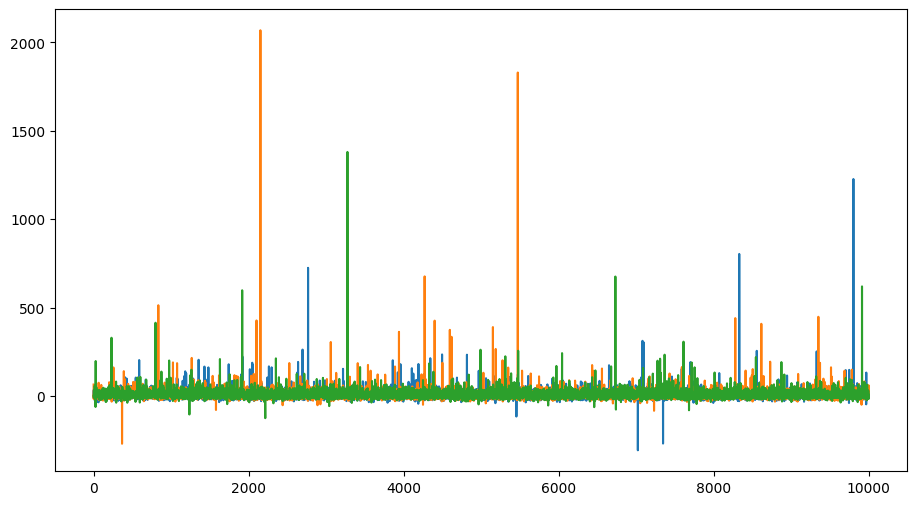

In [4]:
# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs);

# To illustrate the stochasticity, we ploted a couple of more observations with the same parameters:
plt.plot(generation(n,alpha=1.7, beta=0.9, gamma=10, delta=10));
plt.plot(generation(n,alpha=1.7, beta=0.9, gamma=10, delta=10));

<code style="background:LightBlue;color:white"> <strong><em> RQMC sequences </em> </strong> 

In [5]:
#Method 1 using Stratification

In [6]:
def stratified_sampling(a, b, N, K, method='uniform'):
    """
    Generate stratified samples over a specified interval [a, b].
    
    Args:
        a (float): Lower bound of the interval.
        b (float): Upper bound of the interval.
        N (int): Total number of samples to generate.
        K (int): Number of strata.
        method (str): Method of sampling within strata ('uniform', 'single_point', 'middle').

    """
    samples = []
    interval_length = (b - a) / K

    for k in range(K):
        # Calculate the bounds of the k-th interval
        low = a + k * interval_length
        high = low + interval_length

        if method == 'uniform':
            # Generate N/K samples within this interval
            samples.extend(np.random.uniform(low, high, size=N//K))
        elif method == 'single_point':
            # Generate one random sample in each interval
            if N == K:  # Ensure N equals K for this method to work correctly
                samples.append(np.random.uniform(low, high))
            else:
                raise ValueError("N must be equal to K for 'single_point' sampling method.")
        elif method == 'middle':
            # Use the midpoint of each interval
            if N == K:  # Ensure N equals K for this method to work correctly
                midpoint = (low + high) / 2
                samples.append(midpoint)
            else:
                raise ValueError("N must be equal to K for 'middle' sampling method.")
        else:
            raise ValueError("Unsupported method. Choose 'uniform', 'single_point', 'middle'.")

    return np.array(samples)

In [7]:
def alpha_stable_sample_RQMC_stratification(n, alpha, beta=1, gamma=1, delta=0):
    # Initialize samples array with zerros
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    # Random shifts
    random_shift_U = np.random.uniform(-np.pi/2, np.pi/2)
    random_shift_W = np.random.uniform(0, 1)
    
    # Generate stratified U and W with random shift
    U = (stratified_sampling(-np.pi/2, np.pi/2, n, K=100, method='uniform') + random_shift_U) % (np.pi) - np.pi/2
    W = -np.log(1 - (stratified_sampling(0, 1, n, K=100, method='uniform') + random_shift_W) % 1)

    
    # Handle the case alpha = 1 separately
    if alpha != 1:
        part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
        part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
        sample = S_alpha_beta * part1 * part2
    else:
        sample = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [8]:
# Generate a sample
n=10000
y_rqmc1= alpha_stable_sample_RQMC_stratification(n,alpha=1.7, beta=0.9, gamma=10, delta=10)

In [9]:
#Method 2 using Sobol

In [10]:
def alpha_stable_sample_RQMC_sobol(n, alpha, beta=1, gamma=1, delta=0):
    # Initialize samples array with zeros
    sample = np.zeros(n)
    
    # Initialize a Sobol sequence generator with 2 dimensions
    sobol = qmc.Sobol(d=2, scramble=True)
    
    # Generate Sobol points scaled to the ranges of U and W
    points = sobol.random(n)
    # U ranges from -np.pi/2 to np.pi/2, and W is -log(1-U) where U is uniform(0,1)
    U = points[:, 0] * np.pi - np.pi / 2  # Scale first dimension for U
    W = -np.log(1 - points[:, 1])         # Scale second dimension for W

    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    for i in range(n):
        # Handle the case alpha = 1 separately
        if alpha != 1:
            part1 = np.sin(alpha * (U[i] + B_alpha_beta)) / (np.cos(U[i]) ** (1 / alpha))
            part2 = (np.cos(U[i] - alpha * (U[i] + B_alpha_beta)) / W[i]) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
        else:
            sample[i] = (2 / np.pi) * ((np.pi / 2 + beta * U[i]) * np.tan(U[i]) - beta * np.log((np.pi / 2 * W[i] * np.cos(U[i]))/(np.pi/2 + beta * U[i])))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [11]:
# Generate a sample
n=10000
y_rqmc2 = alpha_stable_sample_RQMC_sobol(n,alpha=1.7, beta=0.9, gamma=10, delta=10)

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [12]:
# Apply function and calculate expectations
expect_rqmc = np.mean(np.exp(-y_rqmc2))
expect_mc = np.mean(np.exp(-y_obs))

# Display results
print("RQMC Expected Value: ", expect_rqmc)
print("MC Expected Value: ", expect_mc)

RQMC Expected Value:  1.092993346757946e+288
MC Expected Value:  1.7986611655990595e+129


## ABC setting

Ajouter : pi_lf

In [13]:
def gaussian_ker(u=0, y=0, epsilon=1):
    """gaussian kernel for weights
    
    Parameters
    -------------------
    y : float, or array-like
    the point we have, the output

    u : float, or array-like
    the point from which we want to calculate a weight

    epsilon : int, float
    the scale parameter for which we want to compute the kernel
    ----------
    """

    w = (1/np.sqrt(2*np.pi*(epsilon**2)))*np.exp(-(np.abs((u-y)))**2/(2*(epsilon**2)))
    return w

## Construction of summary stats

### S1 : McCulloch quantiles

In [14]:
def mc_culloch_q(data, gamma=1):
    """fonction pour calculer les quantiles de mc_culloch utilises dans le papier

    Parameters
    --------------
    data : array
    les donnes pour lesquelles on veut calculer les quantiles

    gamma : float
    valeur 1 par defaut, d'apres le papier, on utilise le gamma utilise pour faire les simulations
    ----------------
    """
    data_sorted = np.sort(data)
    useful_quantiles = np.quantile(a=data_sorted, q=[0.95, 0.75, 0.5, 0.25, 0.05])
    q_95 = useful_quantiles[0]
    q_75 = useful_quantiles[1]
    q_50 = useful_quantiles[2]
    q_25 = useful_quantiles[3]
    q_05 = useful_quantiles[4]
    alpha_hat = (q_95-q_05)/(q_75-q_25)
    beta_hat = (q_95+q_05+2*q_50)/(q_95-q_05)
    gamma_hat = (q_75-q_25)/gamma
    #on a le gamma au denominateur parce que c'est comme ca qu on a genere nos donnees
    #d'apres le papier, ca va de prendre le gamma qu'on a utililse pour generer
    delta_hat = np.mean(data_sorted)
    S_1 = np.transpose(np.array((alpha_hat, beta_hat, gamma_hat, delta_hat)))
    return S_1

### S2 Zolotarev transformation

In [15]:
def char_fun_zolo(t, nu, etha, tau):
    """characteristic function to use from S2 to S5

    Parameters
    ----------------------------
    t : float
    the "instant" we want to check

    nu : float
    parameter of the alpha-stable distribution, >= 1/4.

    etha :float
    parameter of the alpha-stable distribution, np.sign(etha) <= min(1, 2*np.sqrt(nu)-1)

    tau : float
    parameter of the alpha-stable distribution, absolute value < inf
    ------------------------------
    """

    y = -np.exp((nu**(-1/2))*(np.log(np.abs(t)) + tau - 1j*(np.pi/2)*etha*np.sign(t)) + np.e*((nu**(-1/2))-1))
    return y



def zolotarev_transfo(sample, xi=0.25):
    """function to use for the estimation based on the zolotarev transformation

    Parameters
    --------------------------
    Sample : array-like
    Sample to do the transformation on

    xi : int, float
    The constant used in the transformation
    --------------------------
    """
    if xi<=0 or xi>1/2 :
        raise ValueError('Xi must be between 0 and 1/2')
    taille = len(sample)
    Z = []
    for i in range(int(taille/3)):
        transfo = sample[3*i-2] - xi*sample[3*i-1] - (1 - xi)*sample[3*i]
        Z.append(transfo)
    V = []
    U = []
    for i in range(len(Z)):
        V.append(np.log(np.abs(Z[i])))
        U.append(np.sign(sample[i]))
    V = np.array(V)
    U = np.array(U)
    S_U_squared = (np.std(U))**2
    S_V_squared = (np.std(V))**2
    nu_tilde = (6/(np.pi)**2)*S_V_squared - (3/2)*S_U_squared + 1
    etha_hat = np.mean(U)
    tau_hat = np.mean(V)
    nu_hat = 0
    if nu_tilde > ((1+np.abs(etha_hat))**2)/4:
        nu_hat = nu_tilde
    else:
        nu_hat = ((1+np.abs(etha_hat))**2)/4
    delta_hat = np.mean(sample)
    S_2 = np.array((nu_hat, etha_hat, tau_hat, delta_hat))
    return S_2

### S3 Press's moments

In [16]:
def u_hat(x, t):
    """function to use to calculate presss moments

    Parameters
    ---------------
    x : array-like

    the data

    t : int, float
    the real number we want to know the image by the function
    ---------------
    """

    y = np.arctan(np.sum(np.cos(t*x))/np.sum(np.sin(t*x)))
    return y


def presss_moments(sample, alpha=1.7, beta=0, gamma=10, delta=10,
                   t_1=0.2, t_2=0.8, t_3=0.1, t_4=0.4):
    """function to calculate press's moments

    Parameters
    ----------------

    sample : array-like
    the data

    alpha, beta, gamma, delta : int, float
    parameters we used to simulate the data (?)

    t_1 : int, float
    t_2 : int, float
    t_3 : int, float
    t_4 : int, float
    moments we want to evaluate, the default parameters are given by Koutrouvelis (1980)
    ---------------
    """
    
    #estimation of characteristic function at different moments
    transfo_1 = th_char_fun(t=t_1, beta=beta)
    transfo_2 = th_char_fun(t=t_2, beta=beta)
    transfo_3 = th_char_fun(t=t_3, beta=beta)
    transfo_4 = th_char_fun(t=t_4, beta=beta)
    log_gamma_hat_top = (np.log(np.abs(t_1))*np.log(-np.log(np.abs(transfo_2)))-np.log(np.abs(t_2))*np.log(-np.log(np.abs(transfo_1))))
    log_gamma_hat = log_gamma_hat_top/np.log(np.abs(t_1/t_2))
    alpha_hat = np.log(np.log(np.abs(transfo_1))/np.log(np.abs(transfo_2)))/np.log(np.abs(t_1/t_2))
    beta_hat_top = ((u_hat(x=sample, t=t_4)/t_4)-(u_hat(x=sample, t=t_3)/t_3))
    beta_hat_bot = ((np.abs(t_4)**(alpha_hat-1))-(np.abs(t_3)**(alpha_hat-1)))*((np.exp(log_gamma_hat))**alpha_hat)*np.tan((alpha_hat*np.pi)/2)
    beta_hat = beta_hat_top/beta_hat_bot
    delta_hat_top = (((np.abs(t_4))**(alpha_hat-1))*u_hat(x=sample, t=t_3)/t_3)-((((np.abs(t_3))**(alpha_hat-1))*u_hat(x=sample,t=t_4))/t_4)
    delta_hat_bot = (np.abs(t_4)**(alpha_hat-1)) - (np.abs(t_3)**(alpha_hat-1))
    delta_hat = delta_hat_top/delta_hat_bot
    y = np.array((alpha_hat, beta_hat, np.exp(log_gamma_hat), delta_hat))
    return y    

#### S4 Empirical characteristic function

In [17]:
def emp_char_fun(sample, t):
    """function to evaluate the empirical characteristic of a function at an instant t

    Parameters
    -------------------------
    sample : array-like
    sample on which we want to evaluate the characteristic function

    t : int, float
    moment to estimate/generate
    --------------------------
    """
    expo_transfo = np.exp(-sample*1j*t)
    empirical = np.mean(expo_transfo)
    return empirical

def th_char_fun(t, alpha=1.7, beta=0.9, gamma=10, delta=10):
    """characteristic function used in the paper

    Parameters
    --------------------------------
    t : float, array-like
    value or values for which we would like to compute the characteristic function, instants/moments

    alpha, beta, gamma, delta : float
    the parameters of our distribution
    ---------------------------------
    """
    if alpha == 1:
        y=np.exp(1j*delta*t-gamma*np.abs(t)*(1+1j*beta*(2/np.pi)*np.sign(t)*np.log(gamma*np.abs(t))))
    else :
        y=np.exp(1j*delta*t-gamma*np.abs(t)*(1+1j*beta*np.tan(np.pi*alpha/2)*np.sign(t)*((np.abs(gamma*t)**(1-alpha))-1)))

    return y

grid = np.arange(-5, 5.5, 0.5)

def emp_charac_sampler(sample, t=grid):
    """A function to compute the S4 statistics from the article.

    Parameters
    -------------------
    sample : array-like
        Data generated given a certain theta (alpha, beta, gamma, delta).

    t : array-like
        Grid used for the empirical characteristic function.

    Returns
    -------------------
    S4 : array-like
        S4 statistics computed using the empirical characteristic function.
    """
    
    median = np.median(sample)
    centered_sample = sample - median
    
    iqr_half = 0.5 * (np.percentile(sample, 75) - np.percentile(sample, 25))
    scaled_sample = centered_sample / iqr_half
    
    def empirical_characteristic_function(t, data):
        return np.mean(np.exp(1j * t * data))
    
    S4 = [empirical_characteristic_function(ti, scaled_sample) for ti in t]
    
    return S4    

### S5 Kolmogorov Smirnov

In [18]:
def emp_cdf(sample,t):
    """a function made to calculate the empirical cumulative distribution function

    Parameters
    ------------------
    sample : array-like
    data, generated or observed

    t : int, float
    the argument in which we want to evaluate the empirical cdf
    ------------------
    """
    result = 0
    sorted_sample = np.sort(sample)
    for i in sorted_sample:
        if i<=t:
            result += 1/len(sample)
    return result

def kolmogorov_smirnov(sample,proposal,q_1=0.25,q_2=0.75):
    """a function to get the S_5 statistic from the article

    Parameters
    ---------------
    sample : array-like
    the observed data about which we want to see if we are close or not 

    proposal : array-like
    the proposal X, simulated from parameters, to see if it fits

    q_1,q_2 : float
    must be between 0 and 1, values to give to have a certain quantile in the summary statistics
    ---------------
    """
    if (0<q_1<1 and 0<q_2<1) == False :
        raise ValueError('q_1 and q_2 must be between 0 and 1')
    KS = 0
    z = np.linspace(start=-400, stop=400, num=100000)
    for i in z:
        interm = np.abs(emp_cdf(sample,i)-emp_cdf(proposal,i))
        if interm>KS:
            KS=interm
    quantiles = np.quantile(a=proposal, q=[q_1, q_2])
    mean_sample = np.mean(proposal)
    return np.array((mean_sample, quantiles[0], quantiles[1], KS))
    

## MCMC

In [19]:
def transition_kernel(theta_current, epsilon=1, Sigma = np.eye(4)):
    """
    Gaussian transition kernel
    
    Parameters:
        theta_current (array_like): current parameters
        epsilon (float): scale parameter
    
    Returns:
        theta_proposed (array_like): proposed parameters.
    """
    noise = np.random.normal(0, epsilon, size=theta_current.shape)
    noise = np.random.multivariate_normal(mean=np.zeros_like(theta_current), cov=Sigma)
    theta_proposed = theta_current + noise
    
    return theta_proposed

proposal = transition_kernel(np.array([1, 2, 3, 4]), epsilon=0.1)

In [20]:
mille = np.linspace(start=100, stop=1000, endpoint=True, num=10)[::-1]
cent = np.linspace(start=10, stop=100, endpoint=False, num=90)[::-1]
dix = np.linspace(start=5, stop=10, endpoint=False, num=10)[::-1]
cinq = np.linspace(start=3, stop=5, endpoint=False, num=40)[::-1]
trois = np.linspace(start=0, stop=3, endpoint=False, num=300)
trois = np.delete(arr=trois, obj=0)
trois = trois[::-1]

epsilon_planning = np.concatenate((mille, cent, dix, cinq, trois))

In [21]:
def mcmc(D, length=100, n = 1000 , c = 1,  alpha=1.7, beta=0.9, gamma=10, delta=10, method='emp_char', true_gamma = 10,var_alpha = 0.05, var_beta = 0.05, var_gamma = 2, var_delta = 4):
    """MCMC without likelihood algorithm, Marjoram et al, 2003

    Parameters
    ---------------------------------
    D : array-like
    data set considered

    length : int
    length of chain

    c : float
    scale parameter for the kernel

    alpha, beta, gamma, delta : float
    parameters proposal for the start of the chain

    true_gamma ::
    the true value of gamma, used in the mcculloch quantiles

    var_alpha, var_beta, var_gamma, var_delta : float
    variance for the transition kernel
    In appendix A, they propose to use 0.25 for the first two and 1 for the last two. 
    However it varies too much for the first two parameters, and too little for the last two. 
    We propose 0.05, 0.05, 2, 4 
    It is to note that if one considers that one of the parameters he proposes is very close to the true value, he can lower the variance for this parameter (even to 0 if one parameter is already known)

    """
    Sigma = np.diag([var_alpha, var_beta, var_gamma, var_delta])
    theta_current = np.array([alpha, beta, gamma, delta])
    theta_proposed = theta_current #initialization
    
    chain = [theta_current]
    accept_count = 0
    t = 0
    
    
    if method == 'zolotarev':
        true_summary_stats = zolotarev_transfo(sample=D, xi=0.15)

    elif method == 'mcculloch':
        true_summary_stats = mc_culloch_q(data=D, gamma = true_gamma)

    elif method == 'press':
        true_summary_stats = presss_moments(sample=D)


    for i in range(1, length):
        
        theta_proposed = transition_kernel(theta_current, c, Sigma)        
    
        if theta_proposed[0] < 0 or theta_proposed[0] > 2 or theta_proposed[1] < -1 or theta_proposed[1] > 1 or theta_proposed[2] <= 0 : #disregarding the case where the parameters are not in the domain
            continue

        data_proposed = generation(n, alpha=theta_proposed[0], beta=theta_proposed[1], gamma=theta_proposed[2], delta=theta_proposed[3])
        
        
        if method == 'zolotarev':
            estimated_summary_stats = zolotarev_transfo(sample=data_proposed, xi=0.15)

        elif method == 'mcculloch':
            estimated_summary_stats = mc_culloch_q(data=data_proposed, gamma = true_gamma)

        elif method == 'press':
            estimated_summary_stats = presss_moments(sample=data_proposed)
        

        if np.linalg.norm(estimated_summary_stats-true_summary_stats) < epsilon_planning[t]:
            accept_count += 1
            t+=1
            theta_current = theta_proposed
            chain.append(theta_current)
            accept_count += 1
            t+=1
            theta_current = theta_proposed
        
            chain.append(theta_current)

    return chain, accept_count / length


In [22]:
true_alpha, true_beta, true_gamma, true_delta = 1.7, 0.9, 10, 10
data = generation(100000, true_alpha, true_beta, true_gamma, true_delta)

In [23]:
theta_estimates = []

# if no idea of the starting parameters, remove the # in front of the lines. Here we specify parameters relatively close to the true ones, especially for gamma and delta
# considering 

for i in range(5):
    alpha_start = 1.2#np.random.uniform(1.01, 2)
    beta_start = 0.4#np.random.uniform(-1, 1)
    gamma_start = 26 #np.random.uniform(0, 30)
    delta_start = 30 #np.random.uniform(-300, 300)
    chain, acceptance_rate = mcmc(D=data, length=1000, n=1000, c=2, alpha=alpha_start, beta=beta_start, gamma=gamma_start, delta=delta_start, true_gamma=true_gamma, method='zolotarev', var_alpha=0.05, var_beta=0.05, var_gamma=1, var_delta=1)
    last_theta = chain[-1]
    print('Acceptance rate is', acceptance_rate*100, '%', '\nLast theta estimate:', last_theta)
    theta_estimates.append(last_theta)


Acceptance rate is 30.599999999999998 % 
Last theta estimate: [ 1.61930535  0.17990765 33.62871451  5.20186872]
Acceptance rate is 14.000000000000002 % 
Last theta estimate: [ 0.75356873  0.34134654 38.71951943 39.42349345]
Acceptance rate is 35.6 % 
Last theta estimate: [ 1.72921526 -0.3113504  23.36358523  7.87469196]
Acceptance rate is 14.000000000000002 % 
Last theta estimate: [ 1.10307435 -0.33563546 15.07271874 36.16267324]
Acceptance rate is 15.6 % 
Last theta estimate: [ 1.22384348  0.96893721 26.67896939 34.88589697]


In [24]:
df_theta_estimates = pd.DataFrame(theta_estimates, columns=['alpha', 'beta', 'gamma', 'delta'])
print(df_theta_estimates)
mean_values = df_theta_estimates.mean()
std_values = df_theta_estimates.std()

print("Mean values:")
print(mean_values)
print("\nStandard deviation values:")
print(std_values)

      alpha      beta      gamma      delta
0  1.619305  0.179908  33.628715   5.201869
1  0.753569  0.341347  38.719519  39.423493
2  1.729215 -0.311350  23.363585   7.874692
3  1.103074 -0.335635  15.072719  36.162673
4  1.223843  0.968937  26.678969  34.885897
Mean values:
alpha     1.285801
beta      0.168641
gamma    27.492701
delta    24.709725
dtype: float64

Standard deviation values:
alpha     0.396340
beta      0.537381
gamma     9.160511
delta    16.697262
dtype: float64


final theta is  [ 1.33875284  0.0987789  10.31588566 11.06466279]
true vaues are 1.7 0.9 10 10


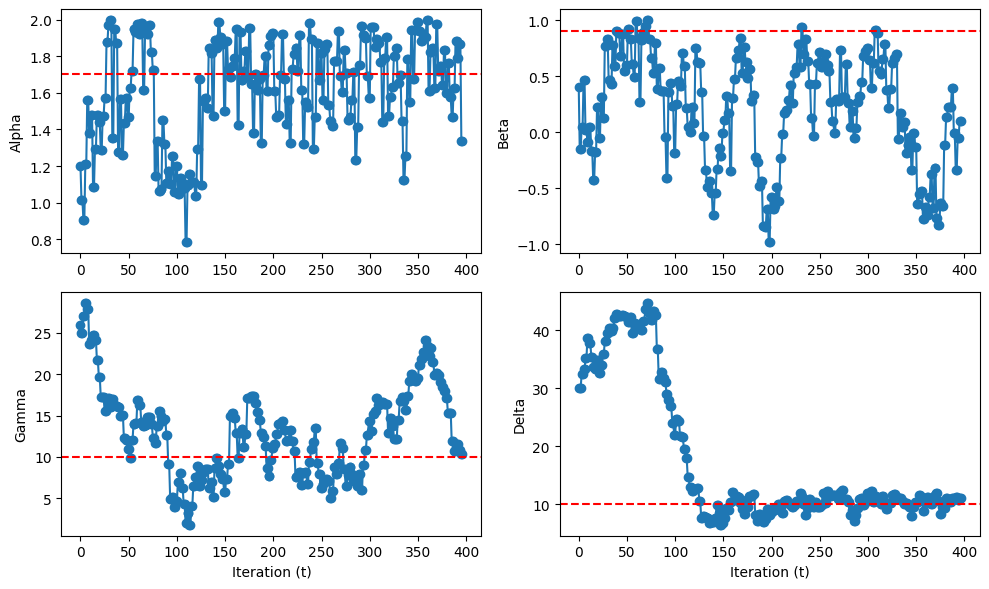

<class 'numpy.float64'>


In [25]:
#Specifiy a certain chain to plot to see how it evolves over acceptance
chain, acceptance_rate = mcmc(D=data, length=1000, n=1000, c=1, alpha=alpha_start, beta=beta_start, gamma=gamma_start, delta=delta_start, true_gamma=true_gamma, method='zolotarev', var_alpha=0.1, var_beta=0.1, var_gamma=3, var_delta=2)
print('final theta is ', chain[-1])
print('true vaues are', true_alpha, true_beta, true_gamma, true_delta) 
   

alpha_values = [chain_item[0] for chain_item in chain]
beta_values = [chain_item[1] for chain_item in chain]
gamma_values = [chain_item[2] for chain_item in chain]
delta_values = [chain_item[3] for chain_item in chain]

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(alpha_values, marker='o')
plt.axhline(y=true_alpha, color='r', linestyle='--', )
plt.ylabel('Alpha')

plt.subplot(2, 2, 2)
plt.plot(beta_values, marker='o')
plt.axhline(y=true_beta, color='r', linestyle='--')
plt.ylabel('Beta')

plt.subplot(2, 2, 3)
plt.plot(gamma_values, marker='o')
plt.axhline(y=true_gamma, color='r', linestyle='--')
plt.xlabel('Iteration (t)')
plt.ylabel('Gamma')

plt.subplot(2, 2, 4)
plt.plot(delta_values, marker='o')
plt.axhline(y=true_delta, color='r', linestyle='--')
plt.xlabel('Iteration (t)')
plt.ylabel('Delta')

plt.tight_layout()
plt.show()


range=[-100,100]
alpha_estimated = alpha_values[-1]
beta_estimated = beta_values[-1]
gamma_estimated = gamma_values[-1]
delta_estimated = delta_values[-1]
print(type(alpha_estimated))